In [69]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable


import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [70]:
torch.cuda.is_available()

True

In [71]:
device

device(type='cuda')

In [72]:
num_eps=10
bsize=32
lrate=0.001
lat_dimension=64 # random noise dim size 
image_sz=64
chnls=1 # mnist dataset은 흑백이니, output channel 1
logging_intv=200

In [73]:
# 문자 생성기
class GANGenerator(nn.Module):
    def __init__(self):
        super(GANGenerator, self).__init__()
        self.inp_sz = image_sz // 4 # 16 
        self.lin = nn.Linear(lat_dimension, 128 * self.inp_sz ** 2) # 64 , 16*16*128로 만들기 위해 > 이후 view를 통해 생성
        self.bn1 = nn.BatchNorm2d(128) 
        self.up1 = nn.Upsample(scale_factor=2) # width ,height가 factor만큼 증가
        self.cn1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128, 0.8)
        self.rl1 = nn.LeakyReLU(0.2, inplace=True)
        self.up2 = nn.Upsample(scale_factor=2)
        self.cn2 = nn.Conv2d(128, 64, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64, 0.8)
        self.rl2 = nn.LeakyReLU(0.2, inplace=True)
        self.cn3 = nn.Conv2d(64, chnls, 3, stride=1, padding=1)
        self.act = nn.Tanh()

    def forward(self, x):
        x = self.lin(x)
        # 128 * self.inp_sz **2  변환 > (channel, width,heigth) (128, 16, 16)
        x = x.view(x.shape[0], 128, self.inp_sz, self.inp_sz)
        x = self.bn1(x)
        # (width, heigth) 업스케일링 
        x = self.up1(x)
        x = self.cn1(x)
        x = self.bn2(x)
        x = self.rl1(x)
        
        x = self.up2(x)
        x = self.cn2(x)
        x = self.bn3(x)
        x = self.rl2(x)
        
        x = self.cn3(x)
        out = self.act(x) # 한장의 이미지 생성 
        return out

In [74]:
# 판독기
class GANDiscriminator(nn.Module):
    def __init__(self):
        super(GANDiscriminator, self).__init__()

        def disc_module(ip_chnls, op_chnls, bnorm=True):
            '''
            conv > leakyR > dropout > batchnorm 
            '''
            mod = [nn.Conv2d(ip_chnls, op_chnls, 3, 2, 1), 
                   nn.LeakyReLU(0.2, inplace=True), 
                   nn.Dropout2d(0.25)]
            if bnorm:
                mod += [nn.BatchNorm2d(op_chnls, 0.8)]
            return mod

        self.disc_model = nn.Sequential(
            *disc_module(chnls, 16, bnorm=False),
            *disc_module(16, 32),
            *disc_module(32, 64),
            *disc_module(64, 128),
        )

        # width and height of the down-sized image
        ds_size = image_sz // 2 ** 4
        self.adverse_lyr = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, x):
        # gen_images 이 input으로 들어옴 
        # gen_images는 random noise 로 생성된 이미지 1장 
    
        x = self.disc_model(x)
        #flatten 
        x = x.view(x.shape[0], -1)
        out = self.adverse_lyr(x)
        return out

In [75]:
# instantiate the discriminator and generator models
gen = GANGenerator().to(device)
disc = GANDiscriminator().to(device)

# define the loss metric
adv_loss_func = torch.nn.BCELoss().to(device)

In [76]:
# define the dataset and corresponding dataloader
dloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist/",
        download=True,
        transform=transforms.Compose(
            [transforms.Resize((image_sz, image_sz)), 
             transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=bsize,
    shuffle=True,
)

# define the optimization schedule for both G and D
opt_gen = torch.optim.Adam(gen.parameters(), lr=lrate)
opt_disc = torch.optim.Adam(disc.parameters(), lr=lrate)

In [80]:
os.makedirs("./images_mnist", exist_ok=True)

for ep in range(num_eps):
    for idx, (images, _) in enumerate(dloader):

        # good_img : (batchsize , channel , width, height)
        # 모든 그림이 1이라 가정
        good_img = Variable(torch.FloatTensor(images.shape[0], 1).fill_(1.0), requires_grad=False).to(device)
        
        # 모든 그림이 0이라 가정
        bad_img = Variable(torch.FloatTensor(images.shape[0], 1).fill_(0.0), requires_grad=False).to(device)

        # get a real image
        actual_images = Variable(images.type(torch.FloatTensor)).to(device)

        # train the generator model
        opt_gen.zero_grad()

        # generate a batch of images based on random noise as input
        noise = Variable(torch.FloatTensor(np.random.normal(0, 1, (images.shape[0], lat_dimension)))).to(device)
        gen_images = gen(noise).to(device)

        # 생성기는 분류기가 good_img라고 판단할 수 있는 이미지를 만들어내야 하기 때문에 만들어낸 img가 모두 통과라는 가정하여 학습
        generator_loss = adv_loss_func(disc(gen_images), good_img)
        generator_loss.backward()
        opt_gen.step()

        opt_disc.zero_grad()

        
        # 1.model은 good_img의 loss를 줄이기 위해 학습 / 2.model은 bad_img의 loss를 줄이기 위해 학습
        # 1+2 를 통해 판별기 학습 (보다 잘 구분해내기 위해)
        actual_image_loss = adv_loss_func(disc(actual_images), good_img) # 
        fake_image_loss = adv_loss_func(disc(gen_images.detach()), bad_img)
        discriminator_loss = (actual_image_loss + fake_image_loss) / 2

        discriminator_loss.backward()
        opt_disc.step()

        batches_completed = ep * len(dloader) + idx
        if batches_completed % logging_intv == 0:
            print(f"epoch number {ep} | batch number {idx} | generator loss = {generator_loss.item()} | discriminator loss = {discriminator_loss.item()}")
            save_image(gen_images.data[:25], f"images_mnist/{batches_completed}.png", nrow=5, normalize=True)

epoch number 0 | batch number 0 | generator loss = 4.009148597717285 | discriminator loss = 0.050809696316719055
epoch number 0 | batch number 200 | generator loss = 1.7755963802337646 | discriminator loss = 0.09203699976205826
epoch number 0 | batch number 400 | generator loss = 2.645019054412842 | discriminator loss = 0.21978366374969482
epoch number 0 | batch number 600 | generator loss = 4.423611640930176 | discriminator loss = 0.12214680761098862
epoch number 0 | batch number 800 | generator loss = 3.4306468963623047 | discriminator loss = 0.10157956182956696
epoch number 0 | batch number 1000 | generator loss = 1.5088939666748047 | discriminator loss = 0.4270232319831848
epoch number 0 | batch number 1200 | generator loss = 3.292675256729126 | discriminator loss = 0.4440552890300751
epoch number 0 | batch number 1400 | generator loss = 1.7279975414276123 | discriminator loss = 0.18356378376483917
epoch number 0 | batch number 1600 | generator loss = 3.3800530433654785 | discrimin

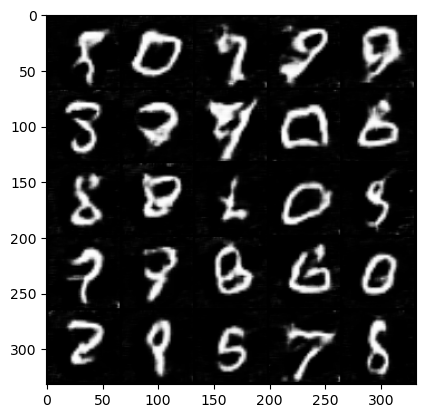

In [82]:
import matplotlib.pyplot as plt

fileName = "./images_mnist/18600.png"

ndarray = plt.imread(fileName)

plt.imshow(ndarray)